# DeepWalk 

# Installation des packages

In [ ]:
!pip install karateclub --upgrade

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=fbd57e9b8fd9125be87757953e013c37b3c7b17c158637546e42e768358f5a01
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


# Importation des packages

In [ ]:
import networkx as nx
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import numpy as np
from karateclub import DeepWalk
import umap.umap_ as umap
from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from gensim.models.word2vec import Word2Vec

# DeepWalk

DeepWalk est un algorithme d'apprentissage non supervisé utilisé pour apprendre des représentations vectorielles de noeuds dans les graphes. Il appartient à la famille des méthodes de représentation de graphe, également appelées embeddings de graphe. L'algorithme a été introduit par Bryan Perozzi, Rami Al-Rfou et Steven Skiena en 2014.

In [8]:
# Charger l'ensemble de données
!wget http://snap.stanford.edu/data/facebook.tar.gz
!tar -xvf "facebook.tar.gz"

facebook.tar.gz     100%[===================>] 714.95K  1.01MB/s    in 0.7s    

2023-12-12 23:35:10 (1.01 MB/s) - ‘facebook.tar.gz’ saved [732104/732104]

facebook/
facebook/3980.egofeat
facebook/0.featnames
facebook/698.egofeat
facebook/3437.feat
facebook/3980.featnames
facebook/0.edges
facebook/3437.circles
facebook/686.circles
facebook/348.egofeat
facebook/107.feat
facebook/348.feat
facebook/1912.circles
facebook/3437.egofeat
facebook/698.feat
facebook/348.edges
facebook/1912.feat
facebook/414.circles
facebook/1684.egofeat
facebook/1684.featnames
facebook/1684.feat
facebook/107.egofeat
facebook/0.circles
facebook/414.edges
facebook/698.featnames
facebook/698.edges
facebook/1912.featnames
facebook/107.edges
facebook/107.circles
facebook/0.egofeat
facebook/414.featnames
facebook/3980.feat
facebook/3437.featnames
facebook/1912.egofeat
facebook/414.egofeat
facebook/698.circles
facebook/348.featnames
facebook/348.circles
facebook/0.feat
facebook/1684.circles
facebook/3437.edges
facebook

In [9]:
## Charger le graphe à partir d'une liste d'arêtes
G = nx.read_edgelist('/content/facebook/0.edges', nodetype=int)

## Génération de l'embedding

La "génération d'embedding pour les graphes" fait référence au processus de création de représentations vectorielles (embeddings) pour les noeuds d'un graphe. Les embeddings de graphe visent à capturer des informations structurelles, topologiques ou sémantiques sur les relations entre les noeuds dans le graphe. Ces représentations vectorielles permettent de transformer des entités du graphe en vecteurs numériques denses, souvent dans un espace de dimension réduite.

In [10]:
len(G.nodes)

333

In [11]:
# Définir explicitement les indices des nœuds
G = nx.convert_node_labels_to_integers(G, first_label=0)

In [12]:
model = DeepWalk(dimensions=10)  # Algorithme d'embedding de nœuds
model.fit(G)  # Appliquer cet algorithme sur le graphe
embedding = model.get_embedding()  # Extraire les embeddings

print('Number  members:', len(G.nodes))
print('Embedding array shape:', embedding.shape)

Number  members: 333
Embedding array shape: (333, 10)


## Projection et affichage de l'embedding sur deux dimensions

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


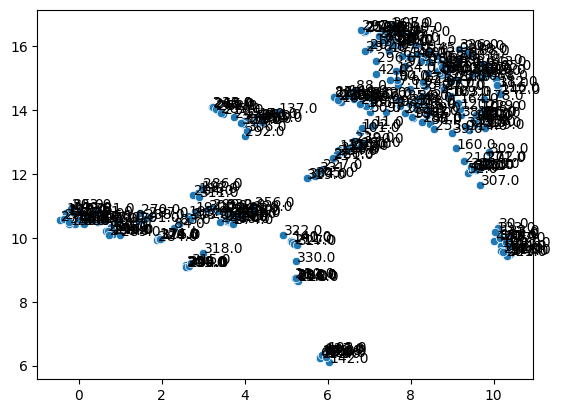

In [13]:
# Utilisation de UMAP pour réduire la dimension des embeddings
u = umap.UMAP(random_state=42)
umap_emb = u.fit_transform(embedding)

# Tracé d'un nuage de points en 2D avec seaborn
ax = sns.scatterplot(x=umap_emb[:, 0], y=umap_emb[:, 1])

# Création d'un DataFrame pour annoter chaque point avec la valeur du nœud dans le graphe
a = pd.DataFrame({'x': umap_emb[:, 0], 'y': umap_emb[:, 1], 'val': G.nodes})

# Ajout des annotations pour chaque point sur le nuage de points
for i, point in a.iterrows():
    ax.text(point['x'] + 0.02, point['y'], str(point['val']))


Il faut remarquer la puissance de cet algorithme à faire apparaitre les clusters du graphe sans avoir besoin du label . Cet embedding sera par la suite utilisé dans n'importe quelle tache de machine learning à savoir classification ou regression ou détection de communautés

# DeepWalk (en étapes)

## Random Walk (en code)

Ecrire une fonction permettant de générer un walk aléatoire de taille en paramètre et en démarrant par un noeud donné

In [14]:
def random_walk(start_node, walk_length):
    walk = [start_node]  # nœud de départ

    for i in range(walk_length):
        all_neighbours = [n for n in G.neighbors(start_node)]  # obtenir tous les voisins du nœud
        next_node = np.random.choice(all_neighbours, 1)[0]  # choisir aléatoirement 1 voisin
        walk.append(next_node)  # ajouter ce nœud à la walk
        start_node = next_node  # ce nœud aléatoire devient maintenant votre état actuel

    return walk

Tester cette fonction pour le noeud 6 et pour une taille de 20 : explorer le walk généré et le modéliser en graphe

In [15]:
G.edges(data=True)

EdgeDataView([(0, 1, {}), (0, 24, {}), (0, 26, {}), (0, 106, {}), (0, 14, {}), (0, 74, {}), (0, 20, {}), (0, 186, {}), (0, 151, {}), (0, 189, {}), (0, 108, {}), (0, 18, {}), (0, 21, {}), (0, 69, {}), (0, 6, {}), (0, 129, {}), (0, 183, {}), (0, 25, {}), (0, 160, {}), (0, 229, {}), (0, 70, {}), (0, 19, {}), (0, 7, {}), (0, 2, {}), (0, 114, {}), (0, 208, {}), (0, 49, {}), (0, 13, {}), (0, 59, {}), (0, 225, {}), (0, 29, {}), (0, 94, {}), (0, 120, {}), (0, 125, {}), (0, 54, {}), (0, 112, {}), (0, 0, {}), (1, 69, {}), (1, 13, {}), (1, 89, {}), (1, 21, {}), (1, 120, {}), (1, 104, {}), (1, 181, {}), (1, 23, {}), (1, 67, {}), (1, 210, {}), (1, 96, {}), (1, 9, {}), (1, 62, {}), (1, 61, {}), (1, 59, {}), (1, 130, {}), (1, 145, {}), (1, 107, {}), (1, 237, {}), (1, 153, {}), (1, 26, {}), (1, 3, {}), (1, 54, {}), (1, 32, {}), (1, 70, {}), (1, 90, {}), (1, 255, {}), (1, 14, {}), (1, 27, {}), (1, 29, {}), (1, 43, {}), (1, 51, {}), (1, 106, {}), (1, 161, {}), (1, 35, {}), (1, 19, {}), (1, 55, {}), (1, 

Steps in random walk: [6, 9, 20, 55, 60, 23, 92, 28, 92, 92, 60, 29, 106, 2, 35, 91, 9, 106, 104, 2, 109]


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  """


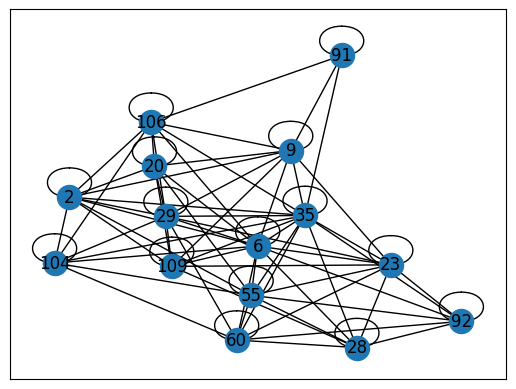

In [16]:
walk = random_walk(6, 20)  # random walk from node 6
print('Steps in random walk:', walk)

walk_graph = G.subgraph(walk)
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos, cmap='coolwarm')

## Random Walk (en fonction)

Utiliser la fonction RandomWalker de Karateclub permettant de générer un nombre de walk aléatoire de taille donnée pour l'ensemble des noeuds du graphe

In [17]:
walker = RandomWalker(walk_length = 10, walk_number = 5)
walker.do_walks(G)  # aux walks dans walker.walks

Expliciter quelques walks générés

In [18]:
walker.walks[0]

['0', '94', '19', '98', '254', '91', '70', '7', '164', '120']

In [19]:
walker.walks[7]

['1', '23', '29', '113', '125', '69', '120', '15', '314', '164']

Nombre de walks générés

In [20]:
len(walker.walks) # 34*5 = 170

1665

## Skip-gram (word2vec)

---
L'objectif principal du modèle Skip-gram est de capturer la structure locale du graphe en apprenant des embeddings de noeuds de manière à ce que les noeuds voisins aient des représentations similaires.


Appliquer la méthode Word2Vec de gensim pour générer un embedding relatif aux walks aléatoires effectués.

In [21]:
model = Word2Vec(walker.walks,  # walks générées précédemment
                 hs=1,  # indique au modèle d'utiliser le softmax hiérarchique
                 sg = 1,  # indique au modèle d'utiliser le skip-gram
                 vector_size=128,  #  taille de l'embedding
                 window=2,
                 min_count=1,
                 workers=4,
                 alpha=0.05,
                 min_alpha=0.0001,
                 negative=5,# par défaut
                 seed=42
                )

La forme des embeddings générés

In [22]:
embeddings = model.wv.vectors
print('Shape of embedding matrix:', embeddings.shape)

Shape of embedding matrix: (333, 128)


Chercher les noeuds similaires à un noeud donné (similarité des embeddings)

In [23]:
# most similar nodes to node '1'
for node, _ in model.wv.most_similar('0'):
    print((node, _))

('1', 0.8420480489730835)
('26', 0.8396812677383423)
('237', 0.8348161578178406)
('29', 0.8280187249183655)
('18', 0.8229177594184875)
('153', 0.8122661709785461)
('189', 0.8107009530067444)
('255', 0.8007115125656128)
('54', 0.7904384136199951)
('106', 0.7870625853538513)
